In [1]:
import torchvision
import torch
from torchvision import transforms
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from zipfile import ZipFile
import random
import PIL
import os
from matplotlib import pyplot as plt

# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#       print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


SEED EVERYTHING

In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
torch.backends.cuda.matmul.allow_tf32 = True # for better mutrix multiplication

LOAD DATA

In [4]:
input_dir = '/content/drive/MyDrive/Детали'
batch_size = 64
rescale_size = 224
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
device

device(type='cuda')

Convert the image to a 255 x 255 image and normalize by mean and standard deviation from ImageNet

In [30]:
transform = transforms.Compose([
    transforms.Resize((int(rescale_size * 1.25), int(rescale_size * 1.25))),
    transforms.RandomCrop(rescale_size),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.8),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [31]:
dataset_full = torchvision.datasets.ImageFolder(root=input_dir, transform=transform)

# split full dataset
train_idx, valid_idx = train_test_split(list(range(len(dataset_full))), train_size=0.88)
dataset = {
    'train': torch.utils.data.Subset(dataset_full, train_idx),
    'valid': torch.utils.data.Subset(dataset_full, valid_idx)
}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}
dataset_classes = np.array(dataset_full.classes)
print('classes:', dataset_classes, '\nsize', dataset_size)

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True, num_workers=2
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset['valid'], batch_size=batch_size, shuffle=False, num_workers=2
    ),
}

classes: ['CS120.01.413' 'CS120.07.442' 'CS150.01.427-01' 'SU160.00.404'
 'SU80.01.426' 'SU80.10.409A' 'ЗВТ86.103К-02' 'СВМ.37.060' 'СВМ.37.060А'
 'СВП-120.00.060' 'СВП120.42.020' 'СВП120.42.030' 'СК20.01.01.01.406'
 'СК20.01.01.02.402' 'СК30.01.01.02.402' 'СК30.01.01.03.403'
 'СК50.01.01.404' 'СК50.02.01.411' 'СПО250.14.190'] 
size {'train': 577, 'valid': 79}


In [32]:
num_classes = len(dataset_classes)
num_classes

19

TRAINING LOOP

In [9]:
from torch.cuda.amp import autocast, GradScaler
import tqdm
# from accelerate import Accelerator
scaler = GradScaler()
# accelerator = Accelerator(gradient_accumulation_steps=4, mixed_precision='fp16')

def train_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim,
    criterion: torch.nn.modules.loss._Loss,
    loader: torch.utils.data.DataLoader,
    device: torch.device
):
    acc_loss = 0
    total = len(loader.dataset)
    # model.to(device)
    model.train()
    for data, target in tqdm.tqdm(loader):
      # with accelerator.accumulate(model): # для имитации большого размера батча (полезно для трансформеров)
        data = data.to(device)
        target = target.to(device)
        pred = torch.nn.functional.softmax(model(data), dim=-1)
        # print(target)
        loss = criterion(pred, target)
        # scaler.scale(loss).backward()
        # scaler.unscale_(optimizer)
        # scaler.step(optimizer)
        loss.backward()
        # accelerator.backward(loss) # вместо loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        acc_loss += loss.item()
    return acc_loss / total


In [10]:
from collections import namedtuple
from typing import NamedTuple, List

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [52]:
from collections import namedtuple
from typing import NamedTuple, List
from torch.utils.mobile_optimizer import optimize_for_mobile
EvalOut = namedtuple("EvalOut", ['loss', 'accuracy'])


def eval_epoch(
    model: torch.nn.Module,
    criterion: torch.nn.modules.loss._Loss,
    loader: torch.utils.data.DataLoader,
    device: torch.device
):
    acc_loss = 0
    accuracy = 0
    total = len(loader.dataset)
    model.eval()
    # model.to(device)
    with torch.inference_mode():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            pred = torch.nn.functional.softmax(model(data), dim=-1)
            loss = criterion(pred, target)
            acc_loss += loss.item()
            accuracy += torch.sum(torch.argmax(pred, 1) == target).item()

    return EvalOut(loss = (acc_loss / total), accuracy = (accuracy / total))


class TrainOut(NamedTuple):
    train_loss: List[float]
    eval_loss: List[float]
    eval_accuracy: List[float]


def train(
    model: torch.nn.Module,
    optimizer: torch.optim,
    criterion: torch.nn.modules.loss._Loss,
    sheduler: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    device: torch.device,
    epochs: int = 10
):
    train_loss = []
    eval_loss = []
    eval_accuracy = []
    model.to(device)
    for i in range(epochs):
        print(f"Epoch - {i}\n")
        if (train_loader != None):
            print("Train...\n")
            train_loss.append(train_epoch(model, optimizer, criterion, train_loader, device))
        print("Validation...\n")
        eval_out = eval_epoch(model, criterion, val_loader, device)
        eval_loss.append(eval_out.loss)
        eval_accuracy.append(eval_out.accuracy)
        print(f'Validation acc: {eval_out.accuracy}')
        sheduler.step()
        print('lr: ', get_lr(optimizer))
        if i > 1 and eval_accuracy[i] == max(eval_accuracy):
        # unwrapped_model = accelerator.unwrap_model(model)
        # accelerator.save({
          #    "model": model.state_dict(),
            # "optimizer": optimizer.optimizer.state_dict() # optimizer is an AcceleratedOptimizer object
          # }, "/content/drive/MyDrive/accel.pth")

          torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          }, f'/content/drive/MyDrive/detail_checkpoint_{i}_simple.pth')

    return TrainOut(train_loss = train_loss,
                    eval_loss = eval_loss,
                    eval_accuracy = eval_accuracy), model


SHOW LOSSES

In [13]:
def show_losses(TrainOut, epochs):
    plt.plot(epochs, TrainOut.train_loss)
    plt.plot(epochs, TrainOut.eval_loss)
    plt.show()

def show_accuracy(accuracy, epochs):
    plt.plot(epochs, accuracy)
    plt.show()

In [16]:
def predict(model, dataloader_test):
    logits = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader_test:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_to_submission(model, dataloader_test=test_loader, test_filenames=test_filenames, dataset_classes=dataset_classes):
    probs = predict(model, dataloader_test)
    print(probs.shape)
    predictions = np.argmax(probs, axis=1)
    preds = dataset_classes[predictions]
    submission = pd.read_csv('/kaggle/input/journey-springfield/sample_submission.csv')
    submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds}).sort_values('Id')
    submission.to_csv('./submission.csv', index=False)

DEFINE MODEL

The base model will be a fine tuned ResNet

In [17]:
from torchvision.models import resnet18

In [53]:
from torch import nn
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(100352, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [46]:
class ServeSimpleCNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.model = SimpleCNN(19)
    # for param in self.mobilenet.parameters():
    #   param.requires_grad = False

    # for j in range(16, 18):
    #   for param in self.mobilenet.features[j].parameters():
    #     param.requires_grad = True

    # for param in self.mobilenet.classifier.parameters():
    #   param.requires_grad = True

    # self.mobilenet.classifier[1] = torch.nn.Linear(1280, 19)

    self.transforms =  torch.nn.Sequential(
            T.Resize(224),  # We use single int value inside a list due to torchscript type restrictions
#            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.transforms(x)
    y = self.model(x)
    return y

In [18]:
class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.requires_grad_(False)
        # self.resnet.layer3[1].requires_grad_(True)
        self.resnet.layer4[1].requires_grad_(True)
        self.classificator = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2, inplace=False),
            torch.nn.Linear(1000, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 19, bias=True)
        )

    def forward(self, x):
        return self.classificator(self.resnet(x))


In [58]:
import torchvision.transforms as T
from torchvision.models import mobilenet_v2
mobilenet = mobilenet_v2(weights='IMAGENET1K_V2')

class MobileNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.mobilenet = mobilenet_v2(weights='IMAGENET1K_V2')
    for param in self.mobilenet.parameters():
      param.requires_grad = False

    for j in range(17, 19):
      for param in self.mobilenet.features[j].parameters():
        param.requires_grad = True

    for param in self.mobilenet.classifier.parameters():
      param.requires_grad = True

    self.mobilenet.classifier[1] = torch.nn.Linear(1280, 19)

    self.transforms =  torch.nn.Sequential(
            T.Resize(224),  # We use single int value inside a list due to torchscript type restrictions
#            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.transforms(x)
    y = self.mobilenet(x)
    return y

In [59]:
model = MobileNet()
# model = ServeSimpleCNN()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
epochs = 60
tr_tuple, model = train(model, optimizer, criterion, sheduler, dataloader['train'], dataloader['valid'], device, epochs)

Epoch - 0

Train...



100%|██████████| 10/10 [01:52<00:00, 11.23s/it]

Validation...



Validation acc: 0.4810126582278481
lr:  0.00099
Epoch - 1

Train...



100%|██████████| 10/10 [01:49<00:00, 10.97s/it]

Validation...



Validation acc: 0.569620253164557
lr:  0.0009801
Epoch - 2

Train...



100%|██████████| 10/10 [01:53<00:00, 11.31s/it]

Validation...



Validation acc: 0.6582278481012658
lr:  0.000970299
Epoch - 3

Train...



100%|██████████| 10/10 [01:50<00:00, 11.00s/it]

Validation...



Validation acc: 0.7215189873417721
lr:  0.0009605960099999999
Epoch - 4

Train...



100%|██████████| 10/10 [01:49<00:00, 10.96s/it]

Validation...



Validation acc: 0.7215189873417721
lr:  0.0009509900498999999
Epoch - 5

Train...



100%|██████████| 10/10 [01:49<00:00, 10.94s/it]

Validation...



Validation acc: 0.8227848101265823
lr:  0.0009414801494009999
Epoch - 6

Train...



100%|██████████| 10/10 [01:49<00:00, 10.99s/it]

Validation...



Validation acc: 0.8227848101265823
lr:  0.0009320653479069899
Epoch - 7

Train...



100%|██████████| 10/10 [01:49<00:00, 10.98s/it]

Validation...



Validation acc: 0.7848101265822784
lr:  0.00092274469442792
Epoch - 8

Train...



100%|██████████| 10/10 [01:49<00:00, 10.97s/it]

Validation...



Validation acc: 0.810126582278481
lr:  0.0009135172474836408
Epoch - 9

Train...



100%|██████████| 10/10 [01:49<00:00, 10.97s/it]

Validation...



Validation acc: 0.810126582278481
lr:  0.0009043820750088043
Epoch - 10

Train...



100%|██████████| 10/10 [01:49<00:00, 10.98s/it]

Validation...



Validation acc: 0.810126582278481
lr:  0.0008953382542587163
Epoch - 11

Train...



100%|██████████| 10/10 [01:49<00:00, 10.96s/it]

Validation...



Validation acc: 0.8607594936708861
lr:  0.0008863848717161291
Epoch - 12

Train...



100%|██████████| 10/10 [01:49<00:00, 10.98s/it]

Validation...



Validation acc: 0.7974683544303798
lr:  0.0008775210229989678
Epoch - 13

Train...



100%|██████████| 10/10 [01:49<00:00, 10.91s/it]

Validation...



Validation acc: 0.8227848101265823
lr:  0.0008687458127689781
Epoch - 14

Train...



100%|██████████| 10/10 [01:49<00:00, 10.92s/it]

Validation...



Validation acc: 0.8481012658227848
lr:  0.0008600583546412883
Epoch - 15

Train...



100%|██████████| 10/10 [01:53<00:00, 11.33s/it]

Validation...



Validation acc: 0.8354430379746836
lr:  0.0008514577710948754
Epoch - 16

Train...



100%|██████████| 10/10 [01:48<00:00, 10.81s/it]

Validation...



Validation acc: 0.8607594936708861
lr:  0.0008429431933839266
Epoch - 17

Train...



100%|██████████| 10/10 [01:46<00:00, 10.69s/it]

Validation...



Validation acc: 0.8227848101265823
lr:  0.0008345137614500873
Epoch - 18

Train...



100%|██████████| 10/10 [01:50<00:00, 11.08s/it]

Validation...



Validation acc: 0.8860759493670886
lr:  0.0008261686238355864
Epoch - 19

Train...



100%|██████████| 10/10 [01:47<00:00, 10.72s/it]

Validation...



Validation acc: 0.8607594936708861
lr:  0.0008179069375972306
Epoch - 20

Train...



100%|██████████| 10/10 [01:46<00:00, 10.69s/it]

Validation...



Validation acc: 0.8607594936708861
lr:  0.0008097278682212583
Epoch - 21

Train...



100%|██████████| 10/10 [01:51<00:00, 11.15s/it]

Validation...



Validation acc: 0.8481012658227848
lr:  0.0008016305895390457
Epoch - 22

Train...



100%|██████████| 10/10 [01:46<00:00, 10.68s/it]

Validation...



Validation acc: 0.8354430379746836
lr:  0.0007936142836436553
Epoch - 23

Train...



100%|██████████| 10/10 [01:46<00:00, 10.65s/it]

Validation...



Validation acc: 0.8987341772151899
lr:  0.0007856781408072188
Epoch - 24

Train...



100%|██████████| 10/10 [01:50<00:00, 11.10s/it]

Validation...



Validation acc: 0.8354430379746836
lr:  0.0007778213593991466
Epoch - 25

Train...



100%|██████████| 10/10 [01:47<00:00, 10.77s/it]

Validation...



Validation acc: 0.8734177215189873
lr:  0.000770043145805155
Epoch - 26

Train...



100%|██████████| 10/10 [01:48<00:00, 10.83s/it]

Validation...



Validation acc: 0.7848101265822784
lr:  0.0007623427143471034
Epoch - 27

Train...



100%|██████████| 10/10 [01:52<00:00, 11.24s/it]

Validation...



Validation acc: 0.8481012658227848
lr:  0.0007547192872036325
Epoch - 28

Train...



100%|██████████| 10/10 [01:47<00:00, 10.75s/it]

Validation...



Validation acc: 0.8354430379746836
lr:  0.0007471720943315961
Epoch - 29

Train...



100%|██████████| 10/10 [01:46<00:00, 10.67s/it]

Validation...



Validation acc: 0.8860759493670886
lr:  0.0007397003733882801
Epoch - 30

Train...



  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
show_losses(tr_tuple, list(range(epochs)))
show_accuracy(tr_tuple.eval_accuracy, list(range(epochs)))

In [ ]:
model.eval()
tens = torch.rand(1, 3, 224, 224)
torchscript_model = torch.jit.trace(model, tens.cuda())
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
torchscript_model_optimized._save_for_lite_interpreter(f"/content/drive/MyDrive/mobilenet_lite_last_1.ptl")


TEST DATSET

In [ ]:
predict_to_submission(model)

(991, 42)


LET`S TRY SOME ENSEMBLES!

In [ ]:
def predict_bagging(models, dataloader_test):
    logits = []
    for model in models:
        model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader_test:
            model_logits = []
            for model in models:
                inputs = inputs.to(device)
                outputs = model(inputs).cpu()
                model_logits.append(outputs)
            logits.append(sum(model_logits) / len(models))
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_to_submission_bagging(models, dataloader_test=test_loader, test_filenames=test_filenames, dataset_classes=dataset_classes):
    probs = predict_bagging(models, dataloader_test)
    print(probs.shape)
    predictions = np.argmax(probs, axis=1)
    preds = dataset_classes[predictions]
    submission = pd.read_csv('/kaggle/input/journey-springfield/sample_submission.csv')
    submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds}).sort_values('Id')
    submission.to_csv('./submission_bag.csv', index=False)

In [ ]:
models = [ResNet() for i in range(5)]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

			Model #0:

Epoch - 0

Train...

Validation...

Epoch - 1

Train...

Validation...

Epoch - 2

Train...

Validation...

Epoch - 3

Train...

Validation...

Epoch - 4

Train...

Validation...

Epoch - 5

Train...

Validation...

Epoch - 6

Train...

Validation...

Epoch - 7

Train...

Validation...

Model #0 best accuracy:  0.9594078319006686


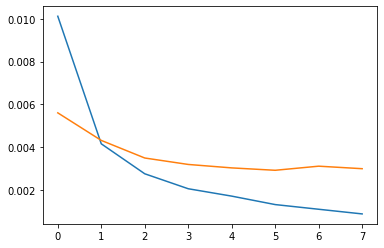

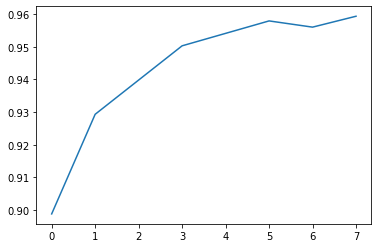

			Model #1:

Epoch - 0

Train...

Validation...

Epoch - 1

Train...

Validation...

Epoch - 2

Train...

Validation...

Epoch - 3

Train...

Validation...

Epoch - 4

Train...

Validation...

Epoch - 5

Train...

Validation...

Epoch - 6

Train...

Validation...

Epoch - 7

Train...

Validation...

Model #1 best accuracy:  0.9603629417383


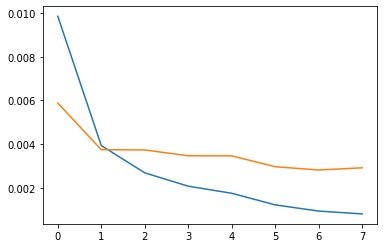

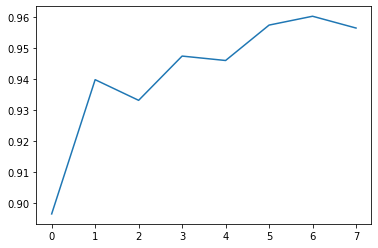

			Model #2:

Epoch - 0

Train...

Validation...

Epoch - 1

Train...

Validation...

Epoch - 2

Train...

Validation...

Epoch - 3

Train...

Validation...

Epoch - 4

Train...

Validation...

Epoch - 5

Train...

Validation...

Epoch - 6

Train...

Validation...

Epoch - 7

Train...

Validation...

Model #2 best accuracy:  0.9579751671442216


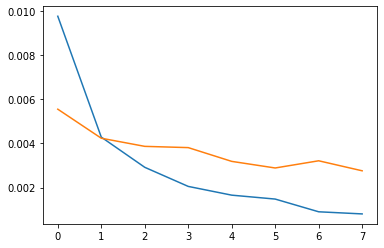

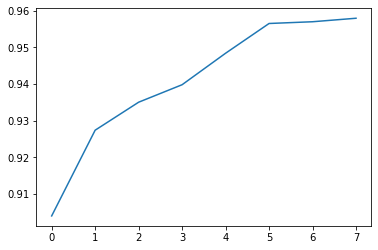

			Model #3:

Epoch - 0

Train...

Validation...

Epoch - 1

Train...

Validation...

Epoch - 2

Train...

Validation...

Epoch - 3

Train...

Validation...

Epoch - 4

Train...

Validation...

Epoch - 5

Train...

Validation...

Epoch - 6

Train...

Validation...

Epoch - 7

Train...

Validation...

Model #3 best accuracy:  0.9632282712511939


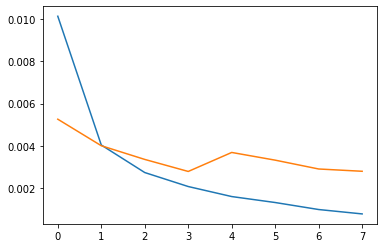

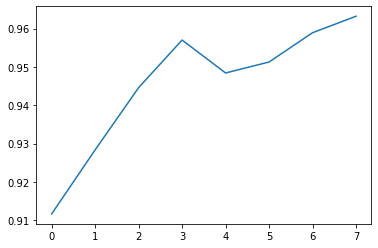

			Model #4:

Epoch - 0

Train...

Validation...

Epoch - 1

Train...

Validation...

Epoch - 2

Train...

Validation...

Epoch - 3

Train...

Validation...

Epoch - 4

Train...

Validation...

Epoch - 5

Train...

Validation...

Epoch - 6

Train...

Validation...

Epoch - 7

Train...

Validation...

Model #4 best accuracy:  0.9541547277936963


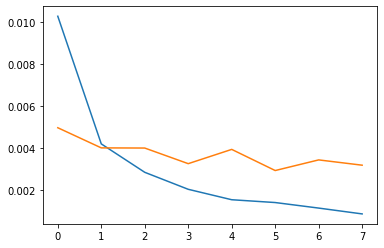

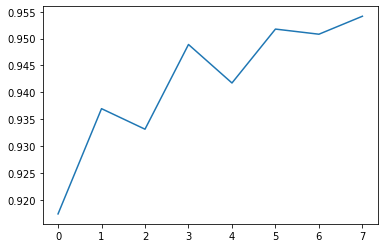

In [ ]:
for i, model in enumerate(models):
    print(f"\t\t\tModel #{i}:\n")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    epochs = 8
    tr_tuple = train(model, optimizer, criterion, sheduler, dataloader['train'], dataloader['valid'], device, epochs)
    print(f"Model #{i} best accuracy: ", max(tr_tuple.eval_accuracy))
    show_losses(tr_tuple, list(range(epochs)))
    show_accuracy(tr_tuple.eval_accuracy, list(range(epochs)))

In [ ]:
predict_to_submission_bagging(models)

(991, 42)


The ensembles gave quality on the best test